# Test Dataloader - DeepGlobe Land Cover Classification

This notebook builds the the test for dataloader to prepare the DeepGlobe dataset for semantic segmentation model training and evaluation. It covers:
- Train/validation split strategy
- Image/mask transforms: normalization, resizing/tiling, and augmentations
- Custom PyTorch Dataset and DataLoader
- Handling class imbalance via class weights and/or sampling
- Saving and visualizing pipeline outputs for sanity checks

## 1.1 Create Train/Val Split

**Objective:** Create a deterministic, stratified train/validation split for the DeepGlobe dataset.

**Why this matters:**
- **Reproducibility:** Fixed random seed yields the same split across runs.
- **No leakage:** Ensures validation images never appear in training.
- **Balanced evaluation:** Stratification by dominant class stabilizes class proportions across splits.
- **Shareable indices:** Persisted JSON lists enable consistent reuse across experiments.

**Dataset assumptions:**
- **Root:** `data/raw/train/`
- **File pattern:** paired files per scene — `"<id>_sat.jpg"` and `"<id>_mask.png"`
- **Mask color map (`COLOR_MAP`):**
  - `(0, 255, 255) → 0` urban
  - `(255, 255, 0) → 1` agriculture
  - `(255, 0, 255) → 2` rangeland
  - `(0, 255, 0) → 3` forest
  - `(0, 0, 255) → 4` water
  - `(255, 255, 255) → 5` barren
  - `(0, 0, 0) → 6` unknown (ignored in stratification)

**Approach:**
- **Convert masks:** `rgb_to_class_id(mask_rgb, COLOR_MAP)` to get per-pixel class IDs.
- **Compute label per image:** Count pixels per class, set class `6` (unknown) to zero, take `argmax` as the image’s dominant class.
- **Stratified split:** Use `train_test_split(..., stratify=dominant_classes, test_size=val_ratio, random_state=seed)`.
- **Persist indices:** Save sorted basenames to `data/splits/train_files.json` and `data/splits/val_files.json`.

**Defaults & knobs:**
- **Validation ratio:** `val_ratio = 0.15`
- **Random seed:** `random_state = 42`
- **Input root:** `../data/raw/train`
- **Output dir:** `../data/splits`

**Outputs:**
- `data/splits/train_files.json` — list of basenames (e.g., `["119", "120", ...]`)
- `data/splits/val_files.json` — list of basenames

**Reproducibility:**
- With a fixed `random_state` and sorted outputs, splits are stable across machines and reruns.

**Notes & caveats:**
- **Dominant-class proxy:** Preserves balance at the image level; for mixed scenes, complement with class-balanced sampling at the tile level during training.
- **Unknown class:** Pixels labeled `6` are excluded from dominant-class computation to avoid skew.
- **Regenerate splits:** If you change `COLOR_MAP`, `val_ratio`, or the dataset root, rerun this step.

In [2]:

import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.create_splits import create_stratified_split, save_splits

train_names, val_names = create_stratified_split('../data/raw/train')
save_splits(train_names, val_names)



Analyzing dominant classes for stratification...


100%|██████████| 803/803 [05:56<00:00,  2.25it/s]


Split summary:
  Total: 803 images
  Train: 682 images (85.0%)
  Val:   121 images (15.0%)

✓ Splits saved to ../data/splits/


## 1.2 Tiling Strategy for Large Images

**Objective:** Efficiently process large DeepGlobe images/masks by splitting them into overlapping tiles and enabling seamless reconstruction.

**Why this matters:**
- **Memory efficiency:** Train/infer on fixed-size tiles to fit GPU memory constraints.
- **Context preservation:** Overlap maintains spatial context at tile borders.
- **Image–mask alignment:** Shared tile coordinates keep images and masks perfectly aligned.
- **Seamless outputs:** Center-weighted blending reduces stitching seams during reconstruction.

This step uses `tile_image` and `reconstruct_from_tiles` from `src/data/tiling.py`. Images and masks are split into `tile_size × tile_size` tiles with `overlap` pixels. During inference, overlapping regions are averaged with a smooth blend mask to avoid seams; for segmentation outputs, average logits/probabilities before `argmax`. Defaults: `tile_size=512`, `overlap=64`.

Original shape: (2448, 2448, 3)
Number of patches: 25
Patch shape: (512, 512, 3)
Reconstructed shape: (2448, 2448, 3)
Reconstruction MSE: 13.4084


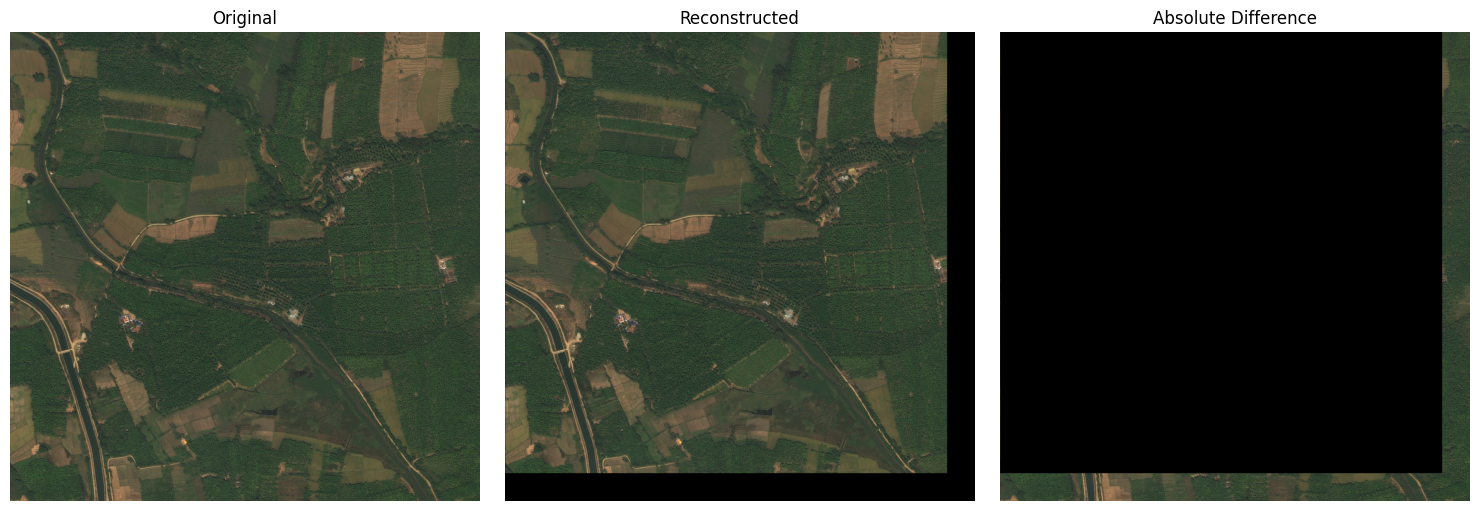

In [3]:
import sys, os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.tiling import tile_image, reconstruct_from_tiles

# Load test image
image = np.array(Image.open('../data/raw/train/119_sat.jpg'))
print(f"Original shape: {image.shape}")

# Tile
patches, coords = tile_image(image, tile_size=512, overlap=64)
print(f"Number of patches: {len(patches)}")
print(f"Patch shape: {patches[0].shape}")

# Reconstruct
reconstructed = reconstruct_from_tiles(patches, coords, image.shape)
print(f"Reconstructed shape: {reconstructed.shape}")

# Calculate reconstruction error
mse = np.mean((image - reconstructed) ** 2)
print(f"Reconstruction MSE: {mse:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title('Original')
axes[1].imshow(reconstructed)
axes[1].set_title('Reconstructed')
axes[2].imshow(np.abs(image - reconstructed))
axes[2].set_title('Absolute Difference')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('../outputs/figures/tiling_test.png', dpi=150)
plt.show()

## 1.3 DeepGlobe Dataset and Dataloader

**Objective:** Provide a standardized pipeline to read images/masks, convert RGB masks to class IDs, apply augmentations, and yield fixed-size tiles as model-ready tensors.

**Key features:**
- **Automatic tiling:** Precomputed tile coordinates consistent with Section 1.2 (`tile_size`, `overlap`).
- **Mask handling:** RGB → class IDs using `COLOR_MAP` via `rgb_to_class_id`.
- **Augmentations:** `get_train_transforms()` and `get_val_transforms()` (normalization + `ToTensorV2`).
- **Outputs:** `image` → `(3, tile_size, tile_size)`, `mask` → `(tile_size, tile_size)` as `LongTensor`.

**Notes:**
- Use `data/splits/train_files.json` and `val_files.json` for file IDs. Data roots: `data/raw/train` and `data/raw/valid`.
- Keep `tile_size`/`overlap` consistent with Section 1.2.
- For visualization, denormalize images; colorize masks from class IDs before overlaying.

In [4]:
import sys, os
import torch
import json

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.dataset import DeepGlobeDataset

# Load split files
with open('../data/splits/train_files.json') as f:
    train_files = json.load(f)

# Create dataset
train_dataset = DeepGlobeDataset(
    data_dir='../data/raw/train',
    file_list=train_files[:10],  # Test with 10 files
    transform=DeepGlobeDataset.get_train_transforms()
)

print(f"Dataset size: {len(train_dataset)} tiles")

# Test loading
image, mask = train_dataset[0]
print(f"Image shape: {image.shape}")  # [3, 512, 512]
print(f"Mask shape: {mask.shape}")    # [512, 512]
print(f"Unique classes: {torch.unique(mask)}")


/Users/ghostface/Projects/mestrado/ml-deepglobe/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset size: 250 tiles
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])
Unique classes: tensor([1, 6])
